In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch.nn as nn
from torchinfo import summary
from torch.optim import Adam
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
notebook_dir= os.path.dirname(os.path.abspath("__file__"))
project_root= os.path.abspath(os.path.join(notebook_dir, '..'))

src_path= os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from config import data_dir, images_train_dir, images_val_dir, labels_train_dir, labels_val_dir, artifacts_dir
import config
from preprocessing import FaceDataset, generate_anchor_boxes, match_anchors_to_gt, filter_valid_bboxes, calculate_iou
from utils import draw_image_with_box, visualize_anchors_and_gt

In [3]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]

['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [4]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, transform= transforms)
train_dataset[1]['image'].shape

torch.Size([3, 224, 224])

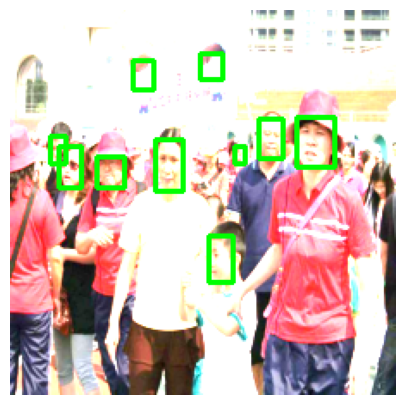

In [5]:
draw_image_with_box(train_dataset[2]['image'], train_dataset[2]['boxes'])

In [6]:
resnet= models.resnet50(pretrained= True)
resnet_backbone= nn.Sequential(*list(resnet.children())[:-4])
torch.save(resnet_backbone, artifacts_dir + "resnet50_backbone.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
resnet_backbone= torch.load(artifacts_dir + "resnet50_backbone.pth")

In [8]:
feature_maps= resnet_backbone(train_dataset[0]['image'].unsqueeze(0))
feature_maps.shape

torch.Size([1, 512, 28, 28])

In [9]:


# Generate anchors using the RESIZED image shape and calculated stride
all_anchors = generate_anchor_boxes(
    config.FEATURE_MAP_SHAPE,
    config.ANCHOR_SCALES,
    config.ANCHOR_RATIOS,
    config.ANCHOR_STRIDE,
    config.NUM_ANCHORS_PER_LOC
)
print(f"Feature map shape: {config.FEATURE_MAP_SHAPE}")
print(f"Resized image shape: {config.IMAGE_SIZE_RESHAPED}")
print(f"Stride: {config.ANCHOR_STRIDE}")
print(f"Scales: {config.ANCHOR_SCALES}, Ratios: {config.ANCHOR_RATIOS}")
print(f"Generated {all_anchors.shape[0]} anchors. Shape: {all_anchors.shape}")
print("First 5 anchors:\n", all_anchors[:5])

Feature map shape: (28, 28)
Resized image shape: (224, 224)
Stride: 8
Scales: [4, 16, 24, 32, 64], Ratios: [0.5, 0.75, 1, 1.5, 2]
Generated 19600 anchors. Shape: torch.Size([19600, 4])
First 5 anchors:
 tensor([[2.5858, 1.1716, 5.4142, 6.8284],
        [2.2679, 1.6906, 5.7321, 6.3094],
        [2.0000, 2.0000, 6.0000, 6.0000],
        [1.5505, 2.3670, 6.4495, 5.6330],
        [1.1716, 2.5858, 6.8284, 5.4142]])


In [10]:
all_anchors

tensor([[  2.5858,   1.1716,   5.4142,   6.8284],
        [  2.2679,   1.6906,   5.7321,   6.3094],
        [  2.0000,   2.0000,   6.0000,   6.0000],
        ...,
        [188.0000, 188.0000, 223.0000, 223.0000],
        [180.8082, 193.8721, 223.0000, 223.0000],
        [174.7452, 197.3726, 223.0000, 223.0000]])

torch.Size([19600, 4])


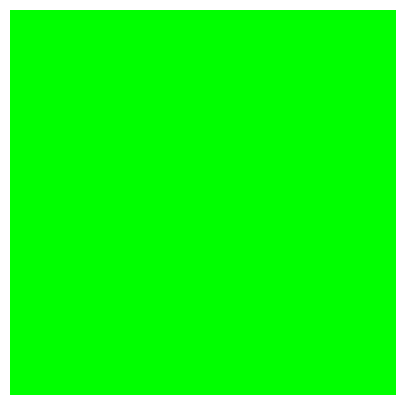

In [11]:
sample_image= train_dataset[2]['image']
sample_label= train_dataset[2]['boxes']

np_image_display= sample_image.detach().cpu().numpy()
np_image_display = np.transpose(np_image_display, (1, 2, 0)) # CxHxW to HxWxC

# Normalize to [0, 255] uint8
if np_image_display.max() <= 1.0:
    np_image_display = (np_image_display * 255).astype(np.uint8)
else:
    np_image_display = np_image_display.astype(np.uint8)

# Ensure contiguous
if not np_image_display.flags['C_CONTIGUOUS']:
    np_image_display = np.ascontiguousarray(np_image_display)
print(all_anchors.shape)
# Draw ALL anchors on the resized image
draw_image_with_box(sample_image, all_anchors)

In [12]:
filtered_bboxes= filter_valid_bboxes(sample_label)
iou= calculate_iou(all_anchors, filtered_bboxes)
all_anchors.shape, iou.shape, filtered_bboxes.shape

(torch.Size([19600, 4]), torch.Size([19600, 10]), torch.Size([10, 4]))

In [13]:
iou.max()

tensor(0.8318)

In [14]:
filtered_boxes= filter_valid_bboxes(sample_label)

In [15]:
keep, matched_labels, gt_assign= match_anchors_to_gt(all_anchors, filtered_bboxes)
num_positive_labels= torch.sum(matched_labels==1)
num_positive_labels

tensor(22)

In [16]:
foreground_mask= matched_labels == 1
pos_anchor_idx= keep[foreground_mask]
pos_anchor_idx

tensor([ 3030,  3031,  3032,  3155,  3156,  6761,  6842,  6860,  6861,  6862,
         6866,  6867,  7080,  7285,  7805,  7806,  7881,  7882,  7883,  7985,
         7986, 12985])

In [17]:
pos_anchors= all_anchors[pos_anchor_idx]

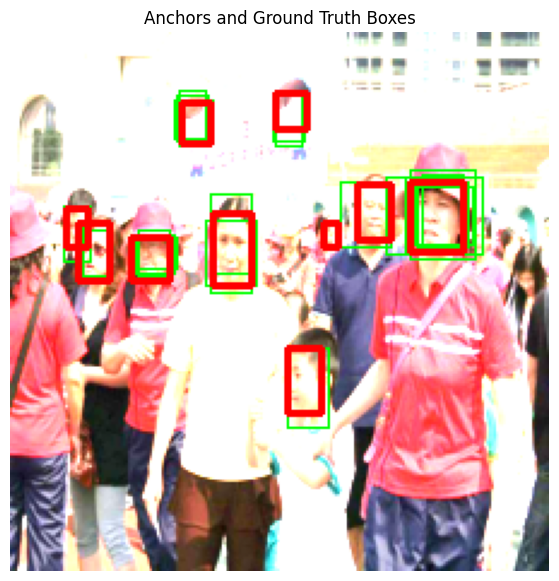

In [18]:
visualize_anchors_and_gt(sample_image, pos_anchors, filtered_bboxes)

In [19]:
def focal_loss(pred_cls, labels, alpha= 0.25, gamma= 2.0, eps= 1e-6):
    mask= labels >= 0
    labels_valid= labels[mask].float()
    prob_cls= torch.sigmoid(pred_cls[mask])
    prob_true= torch.where(labels_valid == 1, prob_cls, 1 - prob_cls)
    focal_weight= alpha * torch.pow(1 - prob_true, gamma)
    loss= F.binary_cross_entropy_with_logits(
        pred_cls[mask], labels_valid, reduction= 'none'
    )
    return (focal_weight * loss).mean()

In [20]:
def bbox_transform(anchors, gt_boxes):
    width_anchors= anchors[:, 2] - anchors[:, 0]
    height_anchors= anchors[:, 3] - anchors[:, 1]
    x_anchors= anchors[:, 0] + width_anchors / 2
    y_anchors= anchors[:, 1] + height_anchors / 2

    width_gts= gt_boxes[:, 2] - gt_boxes[:, 0]
    height_gts= gt_boxes[:, 3] - gt_boxes[:, 1]
    x_gts= gt_boxes[:, 0] + width_gts / 2
    y_gts= gt_boxes[:, 1] + height_gts / 2

    dx= (x_gts - x_anchors) / width_anchors
    dy= (y_gts - y_anchors) / height_anchors
    dw= torch.log(width_gts / width_anchors)
    dh= torch.log(height_gts / height_anchors)

    return torch.stack([dx, dy, dw, dh], dim= 1)

def smooth_l1_loss(pred_reg, targets, beta= 1.0):
    diff= torch.abs(pred_reg - targets)
    loss= torch.where(diff < beta, 0.5 * diff ** 2 / beta, diff - 0.5 * beta)
    return loss.sum(dim= 1) 

In [21]:
class RPN(nn.Module):
    def __init__(self, in_channels= 512, feature_channels= 512, num_anchors_per_location= config.NUM_ANCHORS_PER_LOC):  # 5 scales × 3 ratios
        super(RPN, self).__init__()
        self.conv= nn.Conv2d(in_channels, feature_channels, 3, padding= 1)
        self.cls= nn.Conv2d(feature_channels, num_anchors_per_location, 1)
        self.reg= nn.Conv2d(feature_channels, 4 * num_anchors_per_location, 1)
        self.relu= nn.ReLU(inplace= True)
    def forward(self, x):
        x= self.relu(self.conv(x))
        cls_logits= self.cls(x)
        reg_deltas= self.reg(x)

        batch_size, _, height, width= cls_logits.shape
        cls_logits= cls_logits.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 1)
        reg_deltas= reg_deltas.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        return cls_logits, reg_deltas

In [22]:
len(all_images[:700])

700

In [23]:
train_images, validation_images= train_test_split(all_images[:1000], test_size= 0.2, random_state= 42)
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 10, transform= transforms)
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= validation_images, max_boxes= 10, transform= transforms)
len(val_dataset)

200

In [24]:
train_loader= DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= config.BATCH_SIZE, shuffle= False)

In [25]:
with torch.no_grad():
    feature_maps= resnet_backbone(sample_image.unsqueeze(0))
rpn_model = RPN(in_channels= 512, num_anchors_per_location= config.NUM_ANCHORS_PER_LOC)
summary(rpn_model, input_size= (16, 512, 7, 7))

Layer (type:depth-idx)                   Output Shape              Param #
RPN                                      [16, 1225, 1]             --
├─Conv2d: 1-1                            [16, 512, 7, 7]           2,359,808
├─ReLU: 1-2                              [16, 512, 7, 7]           --
├─Conv2d: 1-3                            [16, 25, 7, 7]            12,825
├─Conv2d: 1-4                            [16, 100, 7, 7]           51,300
Total params: 2,423,933
Trainable params: 2,423,933
Non-trainable params: 0
Total mult-adds (G): 1.90
Input size (MB): 1.61
Forward/backward pass size (MB): 4.00
Params size (MB): 9.70
Estimated Total Size (MB): 15.30

In [29]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print("Generating anchors...")
all_anchors= generate_anchor_boxes(config.FEATURE_MAP_SHAPE,
                                   config.ANCHOR_SCALES,
                                   config.ANCHOR_RATIOS,
                                   config.ANCHOR_STRIDE,
                                   config.NUM_ANCHORS_PER_LOC).to(device)
resnet_backbone= resnet_backbone.to(device)
def forward_and_loss(images, gt_boxes):
    batch_size= images.shape[0]
    features= resnet_backbone(images)
    cls_logits, reg_deltas= rpn_model(features)

    total_cls, total_reg= 0, 0
    for batch in range (batch_size):
        gt_boxes_batch= gt_boxes[batch].to(device)
        keep, matched_labels, gt_assign= match_anchors_to_gt(all_anchors, gt_boxes_batch)
        matched_labels= matched_labels.to(device)
        gt_assign= gt_assign.to(device)
        pos_mask = matched_labels == 1
        reg_targets= bbox_transform(all_anchors[keep][pos_mask], gt_boxes_batch[gt_assign[pos_mask]])

        total_cls+= focal_loss(cls_logits[batch_size, keep], matched_labels)
        if pos_mask.sum() > 0:
            reg_loss= smooth_l1_loss(reg_deltas[batch_size, keep][pos_mask], reg_targets).mean()
            total_reg += reg_loss
    return total_cls / batch_size, total_reg / batch_size

Generating anchors...


In [30]:
@torch.no_grad()
def validate(val_loader):
    rpn_model.eval()
    resnet_backbone.eval()

    total_cls, total_reg, n_samples = 0, 0, 0
    for batch in val_loader:
        images = batch['image'].to(device)
        gt_boxes = [b.to(device) for b in batch['boxes']]

        features = resnet_backbone(images)
        cls_logits, reg_deltas = rpn_model(features)

        for b in range(images.shape[0]):
            gt = gt_boxes[b]
            # --- match WITHOUT balanced sampling ---
            keep, labels, gt_assign = match_anchors_to_gt(
                all_anchors, gt,
                iou_high_threshold=0.5,
                iou_low_threshold=0.2,
                num_samples=999999,   # keep all
                pos_ratio=1.0
            )
            labels = labels.to(device)
            gt_assign = gt_assign.to(device)

            pos_mask = labels == 1
            reg_targets = bbox_transform(all_anchors[keep][pos_mask],
                                       gt[gt_assign[pos_mask]])

            total_cls += focal_loss(cls_logits[b, keep], labels)
            if pos_mask.sum() > 0:
                reg_loss = smooth_l1_loss(reg_deltas[b, keep][pos_mask],
                                        reg_targets).mean()
                total_reg += reg_loss
            n_samples += 1

    rpn_model.train()
    resnet_backbone.train()
    return total_cls / n_samples, total_reg / n_samples

In [31]:
optimizer= torch.optim.Adam(rpn_model.parameters(), lr= config.LEARNING_RATE)

resnet_backbone.eval()
for epoch in range(config.NUM_EPOCHS):
    rpn_model.train()
    for batch in train_loader:
        images= batch['image'].to(device)
        gt_boxes= [boxes for boxes in batch['boxes']]
        cls_loss, reg_loss= forward_and_loss(images, gt_boxes)
        loss= cls_loss, reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1 / config.NUM_EPOCHS} | Objectness Loss Train: {cls_loss.item():.4f} | Reg Loss Train: {reg_loss.item():.4f}")

    val_cls, val_reg= validate(val_loader)
    print(f"Epoch {epoch + 1 / config.NUM_EPOCHS} | Objectness Loss Val: {val_cls.item():.4f} | Regression Loss Val: {val_reg.item():.4f}")
    
    

IndexError: index 32 is out of bounds for dimension 0 with size 32

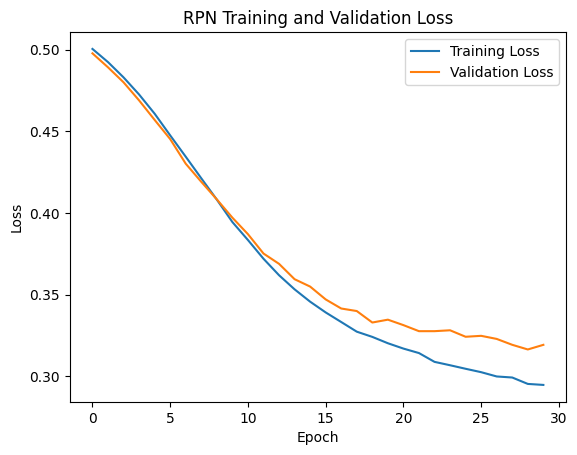

In [ ]:
plt.plot(train_loss_history, label= "Training Loss")
plt.plot(val_loss_history, label= "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RPN Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
def apply_nms(boxes, scores, iou_threshold= 0.7):
    if len(boxes) == 0:
        return torch.empty((0,), dtype= torch.long)
    
    areas= (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    _, order= scores.sort(descending= True)
    keep= []
    while order.numel() > 0:
        i= order[0]
        keep.append(i)
        if order.numel() == 1:
            break
        
        iou= calculate_iou(boxes[i:i+1], boxes[order[1:]])[0]
        mask= iou <= iou_threshold
        order= order[1:][mask]
    return torch.tensor(keep, dtype= torch.long)

In [ ]:
def decode_predictions(all_anchors, reg_deltas, cls_scores, confidence_threshold= 0.1,
                       nms_threshold= 0.7):
    cls_probs= torch.sigmoid(cls_scores)
    confident_mask= cls_probs > confidence_threshold
    if confident_mask.sum() == 0:
        return torch.empty((0, 4)), torch.empty((0,))

    confident_anchors= all_anchors[confident_mask]
    confident_deltas= reg_deltas[confident_mask]
    confident_scores= cls_probs[confident_mask]

    anchor_widths= confident_anchors[:, 2] - confident_anchors[:, 0]
    anchor_heights= confident_anchors[:, 3] - confident_anchors[:, 1]
    anchor_centers_x= confident_anchors[:, 0] + 0.5 * anchor_widths
    anchor_centers_y= confident_anchors[:, 1] + 0.5 * anchor_heights

    pred_centers_x= confident_deltas[:, 0] * anchor_widths + anchor_centers_x
    pred_centers_y= confident_deltas[:, 1] * anchor_heights + anchor_centers_y
    pred_widths= torch.exp(confident_deltas[:, 2]) * anchor_widths
    pred_heights= torch.exp(confident_deltas[:, 3]) * anchor_heights

    pred_boxes= torch.zeros_like(confident_anchors)
    pred_boxes[:, 0]= pred_centers_x - 0.5 * pred_widths
    pred_boxes[:, 1]= pred_centers_y - 0.5 * pred_heights
    pred_boxes[:, 2]= pred_centers_x + 0.5 * pred_widths
    pred_boxes[:, 3]= pred_centers_y + 0.5 * pred_heights

    pred_boxes= torch.clamp(pred_boxes, 0, 1)
    keep_indices= apply_nms(pred_boxes, confident_scores, nms_threshold)

    return pred_boxes[keep_indices], confident_scores[keep_indices]

In [ ]:
def evaluate_model(rpn_model, data_loader, device='cpu'):  # Use test_loader!
    rpn_model.eval()
    
    all_precisions = []
    all_recalls = []
    all_aps = []
    
    # Generate anchors once
    all_anchors = generate_anchor_boxes(
        feature_map_shape=config.FEATURE_MAP_SHAPE,
        image_shape=config.IMAGE_SIZE_RESHAPED,
        scales=config.ANCHOR_SCALES,
        ratios=config.ANCHOR_RATIOS,
        stride=config.ANCHOR_STRIDE
    ).to(device)
    
    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            gt_boxes = batch['boxes'].to(device)
            
            feature_maps = resnet_backbone(images)
            rpn_outputs = rpn_model(feature_maps)
            cls_scores = rpn_outputs['cls_scores']
            reg_deltas = rpn_outputs['reg_deltas']
            
            for i in range(images.size(0)):
                # Skip images with no ground truth
                if gt_boxes[i].numel() == 0:
                    continue
                
                # Decode predictions with lower threshold
                pred_boxes, pred_scores = decode_predictions(
                    all_anchors, 
                    reg_deltas[i], 
                    cls_scores[i], 
                    confidence_threshold=0.1,  # Much lower threshold
                    nms_threshold=0.7
                )
                
                if len(pred_boxes) == 0:
                    all_precisions.append(0.0)
                    all_recalls.append(0.0)
                    all_aps.append(0.0)
                    continue
                
                # Calculate IoU between predictions and ground truth
                iou_matrix = calculate_iou(pred_boxes, gt_boxes[i])
                
                # For each prediction, find best matching ground truth
                max_ious, _ = iou_matrix.max(dim=1)
                
                # Count true positives at IoU threshold 0.5
                true_positives = (max_ious > 0.5).sum().item()
                false_positives = len(pred_boxes) - true_positives
                false_negatives = gt_boxes[i].size(0) - true_positives
                
                precision = true_positives / (true_positives + false_positives + 1e-6)
                recall = true_positives / (true_positives + false_negatives + 1e-6)
                
                all_precisions.append(precision)
                all_recalls.append(recall)
                
                # Simple AP calculation (for single class)
                if precision > 0 and recall > 0:
                    all_aps.append(precision * recall)
                else:
                    all_aps.append(0.0)
    
    # Calculate metrics
    mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0.0
    mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0.0
    mean_ap = sum(all_aps) / len(all_aps) if all_aps else 0.0
    
    return {
        'precision': mean_precision,
        'recall': mean_recall,
        'mAP': mean_ap
    }

# Usage
metrics = evaluate_model(rpn_model, val_loader, device)  # Use test_loader!
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Mean Average Precision (mAP): {metrics['mAP']:.4f}")

Precision: 0.0022
Recall: 0.8990
Mean Average Precision (mAP): 0.0030


In [ ]:
torch.sum(anchor_labels==1).item()

3

In [ ]:
sample_label

tensor([[0.1027, 0.3259, 0.1429, 0.3973],
        [0.1250, 0.3527, 0.1830, 0.4598],
        [0.2232, 0.3795, 0.2946, 0.4598],
        [0.3170, 0.1295, 0.3705, 0.2054],
        [0.3750, 0.3348, 0.4464, 0.4688],
        [0.4911, 0.1116, 0.5491, 0.1786],
        [0.5134, 0.5848, 0.5759, 0.7054],
        [0.5804, 0.3527, 0.6071, 0.3973],
        [0.6429, 0.2812, 0.7054, 0.3839],
        [0.7411, 0.2768, 0.8393, 0.4062]])

Found 10 predictions
Confidence scores: tensor([0.5084, 0.5061, 0.5040, 0.5038, 0.5004, 0.4982, 0.4978, 0.4974, 0.4959,
        0.4950], device='cuda:0')


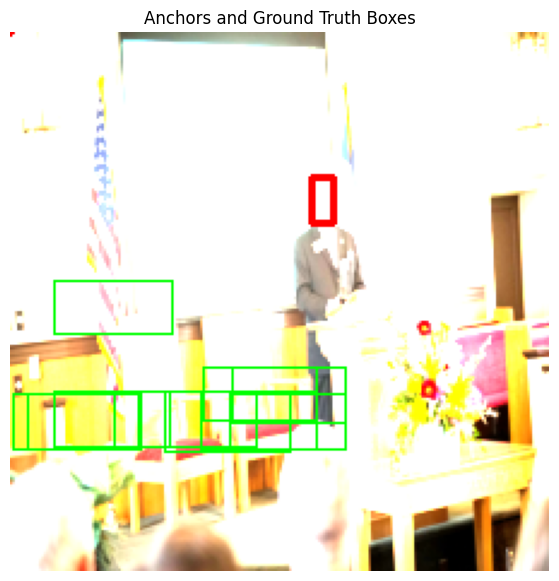

In [ ]:
def get_predictions_for_visualization(rpn_model, resnet_backbone, sample_image, device='cpu', 
                                     confidence_threshold=0.1, nms_threshold=0.7, top_k=10):
    """
    Generate predicted boxes for a single image for visualization
    
    Args:
        rpn_model: Trained RPN model
        resnet_backbone: ResNet backbone
        sample_image: Single image tensor [C, H, W]
        device: Device to run inference on
        confidence_threshold: Minimum confidence for predictions
        nms_threshold: IoU threshold for NMS
        top_k: Number of top predictions to return
    
    Returns:
        predicted_boxes: Tensor of predicted boxes [N, 4]
        confidence_scores: Tensor of confidence scores [N]
    """
    rpn_model.eval()
    resnet_backbone.eval()
    
    # Generate anchors
    all_anchors = generate_anchor_boxes(
        feature_map_shape=config.FEATURE_MAP_SHAPE,
        image_shape=config.IMAGE_SIZE_RESHAPED,
        scales=config.ANCHOR_SCALES,
        ratios=config.ANCHOR_RATIOS,
        stride=config.ANCHOR_STRIDE
    ).to(device)
    
    with torch.no_grad():
        # Add batch dimension if needed
        if sample_image.dim() == 3:
            sample_image = sample_image.unsqueeze(0)
        
        sample_image = sample_image.to(device)
        
        # Forward pass
        feature_maps = resnet_backbone(sample_image)
        rpn_outputs = rpn_model(feature_maps)
        
        cls_scores = rpn_outputs['cls_scores'][0]  # Remove batch dimension
        reg_deltas = rpn_outputs['reg_deltas'][0]  # Remove batch dimension
        
        # Decode predictions
        pred_boxes, pred_scores = decode_predictions(
            all_anchors, 
            reg_deltas, 
            cls_scores, 
            confidence_threshold=confidence_threshold,
            nms_threshold=nms_threshold
        )
        
        # Get top-k predictions
        if len(pred_boxes) > top_k:
            top_indices = torch.topk(pred_scores, top_k)[1]
            pred_boxes = pred_boxes[top_indices]
            pred_scores = pred_scores[top_indices]
        
        return pred_boxes, pred_scores

# Usage example
def visualize_predictions(rpn_model, resnet_backbone, data_loader, device='cpu'):
    """Visualize predictions on a sample image"""
    
    # Get a sample from your data loader
    sample_batch = next(iter(data_loader))
    sample_image = sample_batch['image'][0]  # First image in batch
    sample_gt_boxes = sample_batch['boxes'][0]  # Ground truth boxes
    
    # Get predictions
    predicted_boxes, confidence_scores = get_predictions_for_visualization(
        rpn_model, 
        resnet_backbone, 
        sample_image, 
        device=device,
        confidence_threshold=0.1,  # Lower threshold to see more predictions
        nms_threshold=0.7,
        top_k=10
    )
    
    print(f"Found {len(predicted_boxes)} predictions")
    print(f"Confidence scores: {confidence_scores}")
    
    # Convert to numpy if needed (depending on your visualization function)
    if predicted_boxes.is_cuda:
        predicted_boxes = predicted_boxes.cpu()
    
    # Use your existing visualization function
    visualize_anchors_and_gt(sample_image, predicted_boxes, sample_gt_boxes)
    
    return predicted_boxes, confidence_scores

# Run visualization
predicted_boxes, scores = visualize_predictions(rpn_model, resnet_backbone, val_loader, device)

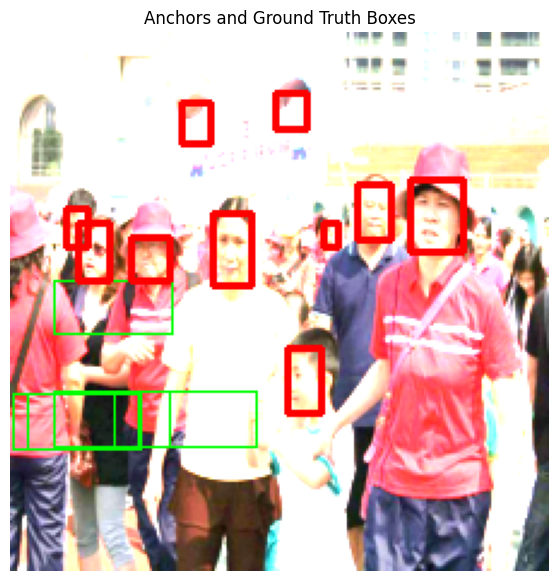

In [ ]:
visualize_anchors_and_gt(sample_image, predicted_boxes[5:10], sample_label)

In [ ]:
def analyze_face_sizes(data_loader):
    face_widths = []
    face_heights = []
    face_areas = []
    
    for batch in data_loader:
        gt_boxes = batch['boxes']
        images = batch['image']
        
        for i in range(len(gt_boxes)):
            boxes = gt_boxes[i]
            img_h, img_w = images[i].shape[1:3]
            
            for box in boxes:
                if box.sum() > 0:  # Valid box
                    # Convert to absolute coordinates
                    x1, y1, x2, y2 = box
                    w = (x2 - x1) * img_w
                    h = (y2 - y1) * img_h
                    area = w * h
                    
                    face_widths.append(w)
                    face_heights.append(h)
                    face_areas.append(area)
    
    face_widths = torch.tensor(face_widths)
    face_heights = torch.tensor(face_heights)
    face_areas = torch.tensor(face_areas)
    
    print("Face Width Stats:")
    print(f"  Min: {face_widths.min():.1f}, Max: {face_widths.max():.1f}")
    print(f"  Mean: {face_widths.mean():.1f}, Median: {face_widths.median():.1f}")
    print(f"  25th percentile: {face_widths.quantile(0.25):.1f}")
    print(f"  75th percentile: {face_widths.quantile(0.75):.1f}")
    
    print("\nFace Height Stats:")
    print(f"  Min: {face_heights.min():.1f}, Max: {face_heights.max():.1f}")
    print(f"  Mean: {face_heights.mean():.1f}, Median: {face_heights.median():.1f}")
    
    print("\nFace Area Stats:")
    print(f"  Min: {face_areas.min():.1f}, Max: {face_areas.max():.1f}")
    print(f"  Mean: {face_areas.mean():.1f}, Median: {face_areas.median():.1f}")
    
    return face_widths, face_heights, face_areas

# Run this to understand your face sizes
face_widths, face_heights, face_areas = analyze_face_sizes(train_loader)

Face Width Stats:
  Min: 0.0, Max: 223.0
  Mean: 23.2, Median: 15.0
  25th percentile: 8.0
  75th percentile: 28.0

Face Height Stats:
  Min: 1.0, Max: 223.0
  Mean: 35.8, Median: 26.0

Face Area Stats:
  Min: 0.0, Max: 49729.0
  Mean: 1457.5, Median: 414.0


In [ ]:
def design_anchors_for_faces(face_widths, face_heights, stride=14):
    """Design anchor scales based on actual face sizes in your dataset"""
    
    # Convert to feature map coordinates
    face_widths_fm = face_widths / stride
    face_heights_fm = face_heights / stride
    
    # Calculate percentiles to cover most faces
    width_percentiles = [
        face_widths_fm.quantile(0.1),
        face_widths_fm.quantile(0.3),
        face_widths_fm.quantile(0.5),
        face_widths_fm.quantile(0.7),
        face_widths_fm.quantile(0.9)
    ]
    
    height_percentiles = [
        face_heights_fm.quantile(0.1),
        face_heights_fm.quantile(0.3),
        face_heights_fm.quantile(0.5),
        face_heights_fm.quantile(0.7),
        face_heights_fm.quantile(0.9)
    ]
    
    # Use geometric mean of width and height for scales
    scales = []
    for w, h in zip(width_percentiles, height_percentiles):
        scale = (w * h) ** 0.5
        scales.append(scale.item())
    
    # Aspect ratios based on face proportions
    aspect_ratios = [0.8, 1.0, 1.2]  # Faces are roughly square but can vary
    
    print(f"Recommended scales: {scales}")
    print(f"Recommended ratios: {aspect_ratios}")
    
    return scales, aspect_ratios

# Usage
scales, ratios = design_anchors_for_faces(face_widths, face_heights)

Recommended scales: [0.4791572690010071, 0.9313141703605652, 1.4106016159057617, 2.3145503997802734, 4.4176130294799805]
Recommended ratios: [0.8, 1.0, 1.2]
